Using optimization approach: predict the configuration of dolphins with a group of 3, 4, 6, 8, and 10 dolphins

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as lin


class Nelder_Mead:
    def __init__(self, dim, volume, param=None, dolphins=3):
        self.dim = dim
        self.num_dolphins = dolphins
        self.simplex = np.zeros(dim * (dim + 1) * dolphins)
        self.simplex = np.reshape(self.simplex, (dolphins, dim + 1, dim))
        self.param = param
        self.cost_func = volume  # fix the cost function
        self.val = np.zeros(dolphins * dim + 1)
        
        # accepted values to use
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 0.5
        self.delta = 0.5
        
        #print(self.simplex)

    def get(self, index, entry=None):
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            self.simplex[index] = np.array(entry)
            if self.param == None:
                self.val[index] = self.cost_func(entry)
            else:
                self.val[index] = self.cost_func(entry, self.param)
            return self.val[index], self.simplex[index]

    def __getitem__(self, index):
        return self.get(index)

    def __setitem__(self, index, entry):
        return self.get(index, entry)

    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]

    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]

    def centroid(self):
        max, min = self.max_min()
        p_bar = np.zeros(self.dim)
        for i in range(max):
            p_bar += self.simplex[i]
        for i in range(max + 1, self.dim + 1):
            p_bar += self.simplex[i]

        p_bar = p_bar/self.dim
        return p_bar #, max

    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p

    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar

    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar

    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl

    def rmsd(self): # root mean square
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average*average))

    def nelder_mead_step(self): # modify this
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        if self.param == None:
            val_r = self.cost_func(p_r)
        else:
            val_r = self.cost_func(p_r, self.param)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            #print(p_ex)
            if self.param == None:
                val_ex = self.cost_func(p_ex)
            else:
                val_ex = self.cost_func(p_ex, self.param)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'

            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'
        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                if self.param == None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                if self.param == None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'

    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            #print(val, index, rms, step_name)
        return nm.simplex[index]
    
def too_close(x):
    for i in x:
        if x[i] - x[i-1] <= 1:
            return True
        else:
            return False
    

def volume(x, p): # 3d add another term
    # x - array
    # p - group size parameter
     
    #return (p[0]*x[0])**2 + (p[1]*x[1])**2
    #if dolphins too far away, cost = p**2
    #elif dolphins too close, cost = p**-2
    if too_close is True:
        cost = (p[0] * x[0] - p[1]) ** -2 + (p[2] * x[1] - p[3]) ** -2 + (p[4] * x[2] - p[5]) ** -2
        return cost
    if too_close is False:
        return (p[0] * x[0] - p[1]) ** 2 + (p[2] * x[1] - p[3]) ** 2 + (p[4] * x[2] - p[5]) ** 2
    

if __name__ == '__main__':
    param = [3.0, 4.0, 2.0, 1.0, 5.0, 2.0]

    # 3n coordinates where n is the number of dolphins. find the cost function.
    # resize in numpy (convienent not needed)
    # cost function p^2 or p^-2
    # more than one solution is possible
    # 4 dolphins have one group tetrahedron
    
    # 3 dolphins
    nm3 = Nelder_Mead(3, volume, param, 3)
    v3, s3 = nm3.get(0, [1, 1, 1])  # value, simplex
    v3, s3 = nm3.get(1, [6, 0, 0])
    v3, s3 = nm3.get(2, [0, 3, 0])
    x3 = nm3.optimize()
    #print(x)

    # 4 dolphins
    nm4 = Nelder_Mead(3, volume, param, 4)
    v4, s4 = nm4.get(0, [1, 1])
    v4, s4 = nm4.get(1, [6, 0])
    v4, s4 = nm4.get(2, [0, 3])
    v4, s4 = nm4.get(3, [2, 5])
    x4 = nm4.optimize()

    # 6 dolphins
    nm6 = Nelder_Mead(3, volume, param, 6)
    v6, s6 = nm6.get(0, [1, 1])
    v6, s6 = nm6.get(1, [6, 0])
    v6, s6 = nm6.get(2, [0, 3])
    v6, s6 = nm6.get(3, [2, 5])
    v6, s6 = nm6.get(4, [1, 5])
    v6, s6 = nm6.get(5, [2, 3])
    x6 = nm6.optimize()

    # 8 dolphins
    nm8 = Nelder_Mead(3, volume, param, 8)
    v8, s8 = nm8.get(0, [1, 1])
    v8, s8 = nm8.get(1, [6, 0])
    v8, s8 = nm8.get(2, [0, 3])
    v8, s8 = nm8.get(3, [2, 5])
    v8, s8 = nm8.get(4, [1, 5])
    v8, s8 = nm8.get(5, [2, 3])
    v8, s8 = nm8.get(6, [4, 3])
    v8, s8 = nm8.get(7, [1, 3])
    x8 = nm8.optimize()

    # 10 dolphins
    nm10 = Nelder_Mead(3, volume, param, 10)
    v10, s10 = nm10.get(0, [1, 1])
    v10, s10 = nm10.get(1, [6, 0])
    v10, s10 = nm10.get(2, [0, 3])
    v10, s10 = nm10.get(3, [2, 5])
    v10, s10 = nm10.get(4, [1, 5])
    v10, s10 = nm10.get(5, [2, 3])
    v10, s10 = nm10.get(6, [4, 3])
    v10, s10 = nm10.get(7, [1, 3])
    v10, s10 = nm10.get(8, [2, 6])
    v10, s10 = nm10.get(9, [0, 5])
    x10 = nm10.optimize()
    
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    Z = np.arange(-5, 5, 0.25)
    XX = [[i for j in Y] for i in X]
    XX = [i for j in XX for i in j]
    
    YY = [[j for k in Z] for j in Y]
    YY = [j for k in YY for j in k]

    ZZ = [[k for i in X] for k in Z]
    ZZ = [k for i in ZZ for k in i]
    # xx yy and zz are indicies
    ZZ = [[[volume((i, j, k), group_size) for i in Y] for j in Z] for k in X]

    ZZ1 = [k for z in ZZ for k in z]

    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection="3d")
    ax.view_init(10, -60)
    surface = ax.plot_trisurf(YY, XX, ZZ1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    xp, yp, zp = x[0], x[1], x[2] # -50
    ax.scatter(xp, yp, zp)
    ax.contourf(X, Y, ZZ, offset=-50.0) ## ZZ used here
    ax.set_zlim([-50, 1000])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

    

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


IndexError: index 3 is out of bounds for axis 0 with size 3

minimal point[2.00229573 0.33620245 0.4019057 ]


TypeError: Input z must be 2D, not 1D

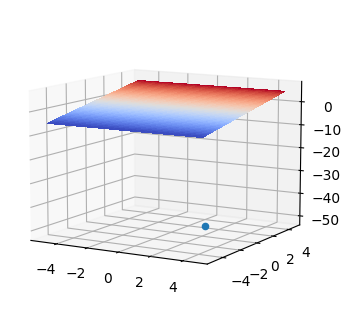

In [123]:
import numpy as np
from numpy import linalg as lin
import matplotlib.pyplot as plt
from matplotlib import cm

class Nelder_Mead:
    def __init__(self, dim, volume, param=None, no_dolphins=3):
        self.dim = dim #* no_dolphins # do not multiply here as it is not 9D its 3D with 3 arrays
       # self.dolphins = no_dolphins # introduce a new self for the new size of the array
        self.simplex = np.zeros([dim*(dim + 1)]) # add dolphins index for correct matrix [3, 12]
        self.simplex = np.reshape(self.simplex, [dim + 1, dim]) # same here [3, 12] -> [4,3]
        self.param = param
        self.cost_func = volume
        self.val = np.zeros(dim + 1)
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.delta = 0.5
        #print(f'simplex: {self.simplex}')  # [ [[000][000][000][000]], [...], [...] ] should be 4, only 3

    def get(self, index, entry=None): # entry is an n dimensional array  get(index, [i, j]) -> get(index, [i, j, k])
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            #print(self.simplex[index])
            self.simplex[index] = np.array(entry)
            if self.param == None:
                self.val[index] = self.cost_func(entry)
            else:
                self.val[index] = self.cost_func(entry, self.param) #, number_dolphins) # added number of dolphins for new cost function
                #print(self.simplex[index])
            return self.val[index], self.simplex[index]

    def __getitem__(self, index):
        return self.get(index)

    def __setitem__(self, index, entry):
        return self.get(index, entry)

    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]

    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]

    def centroid(self):
        max, min = self.max_min()
        p_bar = np.zeros(self.dim)  # p_bar = [0, 0, 0, 0, 0, 0, 0, 0, 0] 9 terms self dim is nine, should be three but with 3 more arrays
        #print(p_bar)  # now its [0, 0, 0] which is good
        for i in range(max):
            p_bar += self.simplex[i] # simplex = [[a, b, c], [a, b, c], [a, b, c]] input values
        for i in range(max + 1, self.dim + 1):
            p_bar += self.simplex[i]

        p_bar = p_bar/self.dim
        # print(f'p_bar {p_bar}') # two terms based on dim.
        # self.dim = 3 so our p_bar should be three terms
        return p_bar #, max

    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p

    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar

    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar

    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl

    def rmsd(self): # root mean square
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average*average))

    def nelder_mead_step(self):
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        if self.param == None:
            val_r = self.cost_func(p_r)
        else:
            val_r = self.cost_func(p_r, self.param)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            if self.param == None:
                val_ex = self.cost_func(p_ex)
            else:
                val_ex = self.cost_func(p_ex, self.param)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'

            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'
        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                if self.param == None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                if self.param == None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'

    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            #print(val, index, rms, step_name)
        return nm.simplex[index]
"""
def volume(x, p, number_dolphins): # not what needs to be changed...
    threshold = 1
    N = len(x)
    pair_distance = np.zeros([N, N])
    for i in range(1, N):
        pair_distance[i, i:N] = number_dolphins[i:N] - number_dolphins[0:N - i]
        print(i, number_dolphins[i:N])
    for i, j in pair_distance:
        if pair_distance[i][j] < threshold:
            return pair_distance ** -2
        else:
            return pair_distance ** 2

    #n+1 points max min simplex
    # spread around an optimum point
    # random
"""
def volume(x, p):
    # works if x[2] is commented out, (x[2] corresponds to a 3d simplex. must be added first), recovers the original. now i have to implement the new cost function with its dependence on the number of dolphins in 3d pairwise distances
    return (p[0] * x[0] - p[1]) ** 2 + (p[2] * x[1] - p[3]) ** 2 #+ (p[4] * x[2] - p[5]) ** 2

def dolphin(x, p):
    number_dolphins = len(x) # 3
    pair_distances = np.zeros([number_dolphins, number_dolphins]) # 3x3
    for i in range(number_dolphins): # 
        
    
    if distance < far_threshold:
        
        
        
"""ef dolphins(dolphin_positions, far_threshold, close_threshold):
    num_dolphins = len(dolphin_positions)
    distances = np.zeros([num_dolphins, number_dolphins])
    
    for i in range(num_dolphins):
        for j in range(i+1, num_dolphins):
            distances[i, j] = np.linalg.norm(hunter_positions[i] - hunter_positions[j])
            distances[j, i] = distances[i, j]      
    
    cost = 0.0
    
    # Penalize if hunters are too far apart
    print(distances)
    for i in len(distances):
        for j in i:
            far_distances = distances[np.where(distances[i][j] > far_threshold)]
            if far_distances.size > 0:
                cost += np.sum(far_distances - far_threshold)
    
    # Penalize if hunters are too close
            close_distances = distances[np.where(distances[i][j] < close_threshold)]
            if close_distances.size > 0:
                cost += np.sum(1.0 / (close_distances + 1e-6))  # Adding a small epsilon to avoid division by zero
    
    return cost"""
if __name__ == '__main__':
    param = [4.0, 8.0, 3.0, 1.0, 2.0, 5.0]
    number_dolphins = 3
    #param = [0, 0, 0, 0]
    #param = [3, 4, 6, 8, 10]
    nm = Nelder_Mead(3, volume, param, number_dolphins)
    v, s = nm.get(0, [1, 1, 1]) # value, simplex
    v, s = nm.get(1, [6, 0, 0])
    v, s = nm.get(2, [0, 3, 0])
    v, s = nm.get(3, [1, 3, 2])
    x = nm.optimize()
    print(f'minimal point{x}')  # -> [x, y, z] minimum point
    
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    XX = [[xx for yy in Y] for xx in X]
    XX = [xx for yy in XX for xx in yy]
    YY = [[yy for yy in Y] for xx in X]
    YY = [xx for yy in YY for xx in yy]
    
    # 2D and volume
    """
    ZZ = [[volume((xx, yy), param) for xx in Y] for yy in X] # plot shows x, y, and potential. we want coordinates for x, y, z of each dolphin
    ZZ1 = [zz for z in ZZ for zz in z]
    """
    
    # add z input to volume
    Z = np.arange(-5, 5, 0.25)
    ZZ = [[zz for yy in Y] for zz in Z]
    ZZ = [zz for z in ZZ for zz in z]
        
    

    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection="3d")
    ax.view_init(10, -60)
    surface = ax.plot_trisurf(YY, XX, ZZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    xp, yp, zp = x[0], x[1], -50
    ax.scatter(xp, yp, zp)
    ax.contourf(X, Y, Z, offset=-50.0)
    ax.set_zlim([-50, 1000])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    




In [119]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

class Nelder_Mead:
    def __init__(self, dim, volume, param=None):
        self.dim = dim
        self.simplex = np.zeros((dim + 1, dim))
        self.param = param
        self.cost_func = volume
        self.val = np.zeros(dim + 1)
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 2.0
        self.delta = 0.5

    def get(self, index, entry=None):
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            self.simplex[index] = np.array(entry)
            if self.param is None:
                self.val[index] = self.cost_func(entry)
            else:
                self.val[index] = self.cost_func(entry, self.param, 1) #hunt far close
            return self.val[index], self.simplex[index]

    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]

    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]

    def centroid(self):
        max_index, min_index = self.max_min()
        p_bar = np.zeros(self.dim)
        for i in range(max_index):
            p_bar += self.simplex[i]
        for i in range(max_index + 1, self.dim + 1):
            p_bar += self.simplex[i]

        p_bar = p_bar / self.dim
        return p_bar

    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p

    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar

    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar

    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl

    def rmsd(self):
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average * average))

    def nelder_mead_step(self):
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        if self.param is None:
            val_r = self.cost_func(p_r)
        else:
            val_r = self.cost_func(p_r, self.param)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            if self.param is None:
                val_ex = self.cost_func(p_ex)
            else:
                val_ex = self.cost_func(p_ex, self.param)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'
            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'
        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                if self.param is None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                if self.param is None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'

    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            print(val, index, rms, step_name)
        return self.simplex[index]

def volume(x, p):
    return (p[0] * x[0] - p[1]) ** 2 + (p[2] * x[1] - p[3]) ** 2 + (p[4] * x[2] - p[5]) ** 2


def dolphins(dolphin_positions, far_threshold, close_threshold):
    num_dolphins = len(dolphin_positions)
    distances = np.zeros([num_dolphins, number_dolphins])
    
    for i in range(num_dolphins):
        for j in range(i+1, num_dolphins):
            distances[i, j] = np.linalg.norm(hunter_positions[i] - hunter_positions[j])
            distances[j, i] = distances[i, j]      
    
    cost = 0.0
    
    # Penalize if hunters are too far apart
    print(distances)
    for i in len(distances):
        for j in i:
            far_distances = distances[np.where(distances[i][j] > far_threshold)]
            if far_distances.size > 0:
                cost += np.sum(far_distances - far_threshold)
    
    # Penalize if hunters are too close
            close_distances = distances[np.where(distances[i][j] < close_threshold)]
            if close_distances.size > 0:
                cost += np.sum(1.0 / (close_distances + 1e-6))  # Adding a small epsilon to avoid division by zero
    
    return cost



if __name__ == '__main__':
    
    """
    # Example usage:
    hunter_positions = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
    prey_position = np.array([0, 0, 0])
    far_threshold = 2.0
    close_threshold = 1.0

    cost = dolphins(hunter_positions, far_threshold, close_threshold)
    print("Cost:", cost)
"""


    param = [4.0, 8.0, 3.0, 1.0, 2.0, 5.0]
    nm = Nelder_Mead(3, volume, param)
    v, s = nm.get(0, [1, 1, 1])
    v, s = nm.get(1, [6, 0, 1])
    v, s = nm.get(2, [0, 3, 1])
    x = nm.optimize()

    # Visualization code remains the same as in the original example
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    Z = np.arange(-5, 5, 0.25)

    XX, YY, ZZ = np.meshgrid(X, Y, Z)
    XYZ = np.column_stack((XX.ravel(), YY.ravel(), ZZ.ravel()))
    ZZ1 = np.array([volume(point, param) for point in XYZ])

    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection="3d")
    ax.view_init(10, -60)
    surface = ax.plot_trisurf(XYZ[:, 1], XYZ[:, 0], ZZ1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    xp, yp, zp = x[0], x[1], x[2]
    ax.scatter(yp, xp, zp)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()


TypeError: volume() takes 2 positional arguments but 3 were given